In [1]:
# ------------------------------------------------------------------------
# Author: Euihyun Choi, Structural Engineering Intern. Date: July 20, 2022
# AECOM Technical Services Inc. 
# Project: Pilarcitos Dam and Reservoir Improvement Project
# Task: Preliminary design of Labyrinth weir
# ------------------------------------------------------------------------

import os
import numpy as np
import re
import matplotlib.pyplot as plt
import imageio
import random
from shapely.geometry import LineString, Point, Polygon

# Standard Units
ft = 1
kips = 1

# Dependant Units
inch = ft/12
lb = kips/1000
pcf = lb/ft**3
ksi = kips/inch/inch
psi = lb/inch/inch

# Material Properties
gamma_conc = 150 * pcf # Concrete density
gamma_w = 62.4 * pcf # Water unit weight
fc = 4 * ksi
fy = 60 * ksi

# Geotech Input
gamma_soil = 130 * pcf # Soil unit weight
Ka = 0.30
Ka_eq = 0.50
Kp = 3
mu = 0.6745
c = 0
PGA = 0.95
kh = 0.7

# Water Level
El_NWS = 696.5*ft # Normal Water Surface Elevation

L_weir_req = 450*ft
El_weir_crest = 696.5*ft
level = [705, 700, 695, 690, 685, 680, 675, 670, 665, 660, 655]

%run -i "data_read.ipynb"

In [2]:
# Dimensions
ts = 60*inch
tk = 36*inch
hk = 80*inch
hw = 11.5*ft
hw_b = 15*ft
tw_b = 48*inch
L_heel = 12*ft
Lk_b = 6*ft
hk_b = 80*inch
tk_b = 48*inch
hs = hk + ts

# Plan dimensions
B = 54*ft
A1 = 5*ft
A2 = 2*ft
tw = 4*ft
L1 = 75*ft
L2 = 100*ft
theta = 110/180*np.pi
We = 10*ft
W = 65*ft
L3 = np.sqrt(L1**2+L2**2-2*L1*L2*np.cos(theta))
W_min = L3/2 - We

w = (W/2 - (A1+A2))/2
L = B-tw

lw = (L**2+w**2)**0.5
Lw = (lw*2 + A1 + A2)*4 + 2*We

print("Minimum Weir width for two cycles (W):", W_min, "ft")
print("Overall Weir Length: ", Lw, "ft")

# Sliding stability
A_base1 = 0.5*(A1+W/2)*B
V1 = A_base1*ts+(lw*2+A1+A2)*(tw*hw+tk*hk)

A_base2 = np.sqrt((W+We)**2-(L3/2)**2)*L3/2 + L1*L2*np.sin(theta)/2 + L_heel*(L1+L2)
V2 = A_base2*ts + (L1+L2)*(tw_b*hw_b+tk_b*hk_b)

Vol = V1*4 + V2 + 2*We*(tw*hw+tk*hk)
Area = A_base1*4+A_base2

W_conc = Vol*gamma_conc
Fu = Area*gamma_w*(hw+ts)
F_anc = 200*kips
theta_anc = 20/180*np.pi

P1 = L1*(((gamma_soil-gamma_w)*(Ka_eq+Ka)+gamma_w)*0.5*(hw_b+ts)**2)-0.5*L1*(gamma_soil - gamma_w)*Kp*0.5*(hk)**2
P2 = L2*(((gamma_soil-gamma_w)*(Ka_eq+Ka)+gamma_w)*0.5*(hw_b+ts)**2)-0.5*L2*(gamma_soil - gamma_w)*Kp*0.5*(hk)**2
T_anc1 = 18*F_anc*np.cos(theta_anc)
T_anc2 = 24*F_anc*np.cos(theta_anc)
T_anc = np.sqrt(T_anc1**2+T_anc2**2-2*T_anc1*T_anc2*np.cos(theta))
Weq = W_conc*PGA*2/3
T = Weq + np.sqrt(P1**2+P2**2-2*P1*P2*np.cos(theta)) - T_anc
Pp =  0.5*L3*(gamma_soil - gamma_w)*Kp*0.5*hs**2 + L3*gamma_w*0.5*(hw+ts)**2 - L3*gamma_w*7/12*kh*(hw+hk+ts-hs)**2

W_soil = L_heel*(L1+L2)*hw_b*gamma_soil
N = W_conc - Fu +W_soil
FS_slide = (N*mu)/(T-Pp)
print("V/A", Vol/Area, "----ts:", ts)
print("+Tot weight", W_conc, "kips")
print("+Soil weight", W_soil, "kips")
print("-Floatation", Fu, "kips")
print("= Net Normal", N, "kips")
print("+EQ inertia", Weq, "kips")
print("+Actives", np.sqrt(P1**2+P2**2-2*P1*P2*np.cos(theta)),"kips")
print("-Anchor", T_anc, "kips")
print("= Tangential", T, "kips")
print("Passive", Pp, "kips")
print("Factor of Safety against Sliding:", FS_slide)

Minimum Weir width for two cycles (W): 62.0335028821399 ft
Overall Weir Length:  460.8001937984041 ft
V/A 9.077514066192148 ----ts: 5.0
+Tot weight 15220.610861937477 kips
+Soil weight 4095.0 kips
-Floatation 11509.128181407921 kips
= Net Normal 7806.482680529556 kips
+EQ inertia 9639.720212560402 kips
+Actives 3031.5539799624853 kips
-Anchor 6498.177706339904 kips
= Tangential 6173.096486182983 kips
Passive 1732.4494446405465 kips
Factor of Safety against Sliding: 1.1857444464192877


In [3]:
# Check Overturning
V_base = A_base1*ts
V_wall = (lw*2+A1+A2)*tw*hw
V_key = (lw*2+A1+A2)*tk*hk

c_base = (W/6+2*A1/3)/(W/2+A1)*B

Moments = []
# positive moment
W_base = V_base*gamma_conc
r_W_base = c_base
Moments.append(W_base*r_W_base)

W_wall = V_wall*gamma_conc
r_W_wall = B/2
Moments.append(W_wall*r_W_wall)

W_key = V_key*gamma_conc
r_W_key = B/2
Moments.append(W_key*r_W_key)

# negative moment
W_base_eq = W_base*PGA*2/3
r_W_base_eq = ts/2
Moments.append(-W_base_eq*r_W_base_eq)

W_wall_eq = W_wall*PGA*2/3
r_W_wall_eq = ts+hw/2
Moments.append(-W_wall_eq*r_W_wall_eq)

W_key_eq = W_key*PGA*2/3
r_W_key_eq = -hk/2
Moments.append(-W_key_eq*r_W_key_eq)

Fu_base = A_base1*(hw+ts)*gamma_w
r_Fu_base = c_base
Moments.append(-Fu_base*r_Fu_base)

Pp_over = 0.5*W/2*(gamma_soil - gamma_w)*Kp*0.5*hk**2
r_Pp_over = hk*2/3
Moments.append(-Pp_over*r_Pp_over)

Pa_over = W/2*(gamma_soil - gamma_w)*Ka*0.5*hs**2
r_Pa_over = hs/3 - hk
Moments.append(-Pa_over*r_Pa_over)

Pa_eq_over = W/2*(gamma_soil - gamma_w)*Ka_eq*0.5*hs**2
r_Pa_eq_over = 2*hs/3 - hk
Moments.append(-Pa_eq_over*r_Pa_eq_over)

Fw = W/2*gamma_w*0.5*(ts + hw)**2
r_Fw = (ts + hw)/3
Moments.append(-Fw*r_Fw)

h_water = hw+ts+hk - hs
Fw_eq = W/2*7/12*kh*gamma_w*h_water**2
r_Fw_eq = (hs-hk) + h_water*0.4
Moments.append(-Fw_eq*r_Fw_eq)

M_res = 0
M_over = 0
for moment in Moments:
    if moment >= 0:
        M_res += moment
    else:
        M_over += -moment
print("Overturning Moment:", M_over, "kips-ft")
print("Resisting Moment:", M_res, "kips-ft")
FS_over = M_res/M_over
print("Factor of Safety against Overturning:", FS_over)

Overturning Moment: 30623.895603942372 kips-ft
Resisting Moment: 45770.25497038879 kips-ft
Factor of Safety against Overturning: 1.494592835684058


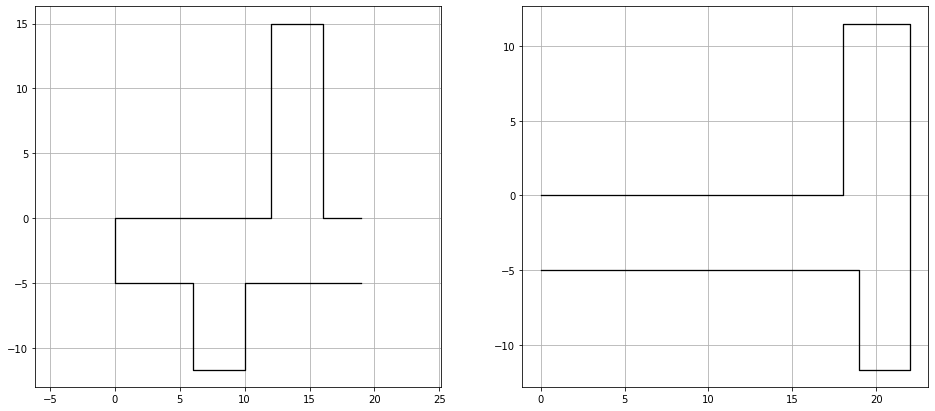

In [4]:
%run -i "section_plot.ipynb"

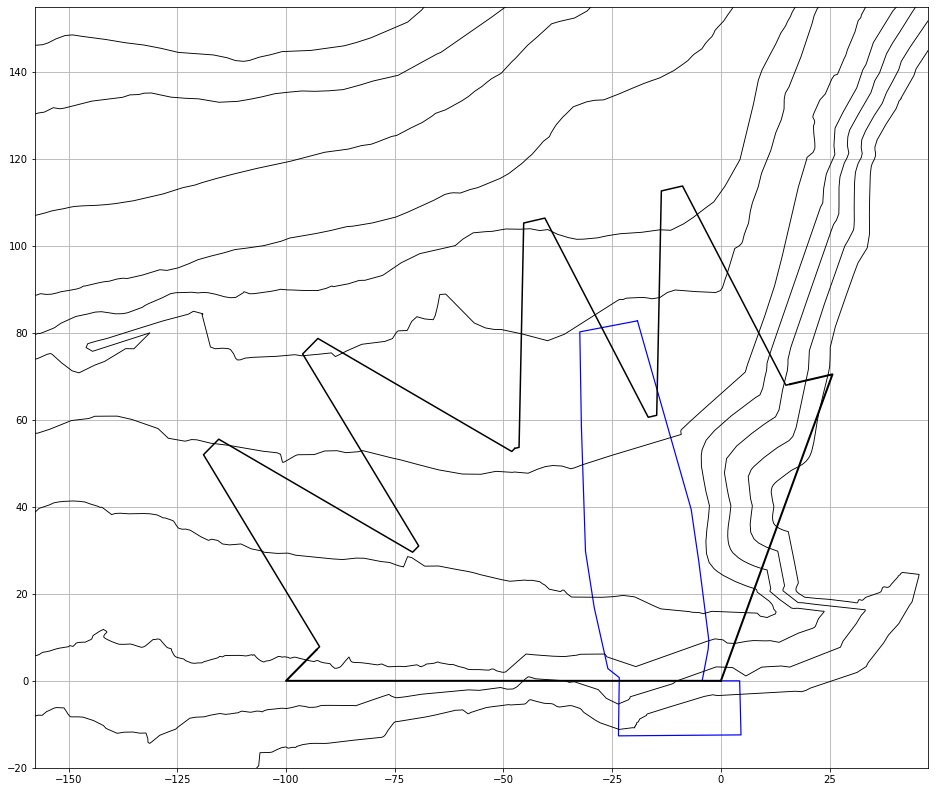

In [40]:
%run -i "plan_plot.ipynb"